# Modelagem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)

import warnings

# remoção segura para deixar o log mais limpo
warnings.filterwarnings("ignore", message="X does not have valid feature names") 

## Pré-processamento dos dados para o modelo 

Leitura do dataset de features e covertendo os tipos dos dados

In [2]:
# Leitura do dataset
dataset_features_v1 = pd.read_csv('../data/processed/dataset_features_v1.csv')

# Conversão dos tipos numéricos e categóricos
dataset_features_v1 = dataset_features_v1.astype({
    'ID_CLIENTE': 'int64',
    'VALOR_A_PAGAR': 'float64',
    'TAXA': 'float64',
    'RENDA_MES_ANTERIOR': 'float64',
    'NO_FUNCIONARIOS': 'int64',
    'FLAG_PF': 'int64',
    'DIAS_ATRASO': 'int64',
    'TARGET_INADIMPLENCIA': 'int64',
    'DIAS_ADIANTAMENTO': 'int64',
    'TEMPO_DE_CASA_MESES': 'int64',
    'PRAZO_PAGAMENTO_DIAS': 'int64',
    'MES_SAFRA': 'int32',
    'INADIMPLENCIAS_ANTERIORES': 'int64',
    'SEGMENTO_INDUSTRIAL': 'category',
    'DOMINIO_EMAIL': 'category',
    'PORTE': 'category',
    'CEP_2_DIG': 'category',
})

# Conversão de datas
dataset_features_v1['SAFRA_REF'] = pd.to_datetime(
    dataset_features_v1['SAFRA_REF'], format='%Y-%m-%d', errors='coerce'
)

dataset_features_v1['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(
    dataset_features_v1['DATA_EMISSAO_DOCUMENTO'], format='%Y-%m-%d', errors='coerce'
)

dataset_features_v1['DATA_PAGAMENTO'] = pd.to_datetime(
    dataset_features_v1['DATA_PAGAMENTO'], format='%Y-%m-%d', errors='coerce'
)

dataset_features_v1['DATA_VENCIMENTO'] = pd.to_datetime(
    dataset_features_v1['DATA_VENCIMENTO'], format='%Y-%m-%d', errors='coerce'
)

dataset_features_v1['DATA_CADASTRO'] = pd.to_datetime(
    dataset_features_v1['DATA_CADASTRO'], format='%Y-%m-%d', errors='coerce'
)


In [3]:
dataset_features_v1.dtypes

ID_CLIENTE                            int64
SAFRA_REF                    datetime64[ns]
DATA_EMISSAO_DOCUMENTO       datetime64[ns]
DATA_PAGAMENTO               datetime64[ns]
DATA_VENCIMENTO              datetime64[ns]
VALOR_A_PAGAR                       float64
TAXA                                float64
RENDA_MES_ANTERIOR                  float64
NO_FUNCIONARIOS                       int64
DATA_CADASTRO                datetime64[ns]
FLAG_PF                               int64
SEGMENTO_INDUSTRIAL                category
DOMINIO_EMAIL                      category
PORTE                              category
CEP_2_DIG                          category
DIAS_ATRASO                           int64
TARGET_INADIMPLENCIA                  int64
DIAS_ADIANTAMENTO                     int64
TEMPO_DE_CASA_MESES                   int64
PRAZO_PAGAMENTO_DIAS                  int64
MES_SAFRA                             int32
INADIMPLENCIAS_ANTERIORES             int64
ADIANTAMENTOS_ANTERIORES        

#### Remoção de colunas irrelevantes

Comecei eliminando colunas que não agregam valor ao modelo.

* **ID_CLIENTE** é apenas um identificador único, não possui utilidade preditiva.
* As colunas de datas brutas (**DATA_EMISSAO_DOCUMENTO**, **DATA_PAGAMENTO**, **DATA_VENCIMENTO**, **DATA_CADASTRO** e **SAFRA_REF**) foram removidas porque já foram utilizadas para criar variáveis derivadas mais informativas.

#### Prevenção de data leakage

* As variáveis **DIAS_ATRASO** e **DIAS_ADIANTAMENTO** foram retiradas porque só estariam disponíveis após o vencimento, ou seja, depois da ocorrência ou não da inadimplência.
* Manter essas colunas geraria vazamento de informação (data leakage), prejudicando a generalização do modelo e provocando overfitting.

#### Codificação de variáveis categóricas

* As variáveis **SEGMENTO_INDUSTRIAL**, **PORTE** e **DOMINIO_EMAIL**, por serem categóricas com baixa cardinalidade, foram tratadas com One-Hot Encoding.
* Já a variável **CEP_2_DIG** apresenta alta cardinalidade, e por isso utilizei Frequency Encoding, uma técnica que substitui cada categoria pela frequência relativa com que aparece na base de dados. Isso evita a explosão de colunas sem perder a representatividade da variável.

#### Separação dos dados

* Após o pré-processamento, separei as variáveis explicativas (**X**) da variável alvo (**TARGET_INADIMPLENCIA**).
* Em seguida, fiz a divisão entre treino e teste com **train_test_split**, utilizando **stratify=y** para garantir a mesma proporção de inadimplentes em ambas as amostras.


In [4]:
# Eliminar colunas irrelevantes
cols_drop = [
    'ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO',
    'DATA_VENCIMENTO', 'DATA_CADASTRO', 'SAFRA_REF',
    'DIAS_ATRASO', 'DIAS_ADIANTAMENTO', # Colunas que só são conhecidas depois do treinamento. São removidas para evitar data leakage
]

df = dataset_features_v1.drop(columns=cols_drop)

# Aplicando One-Hot Encoding em variáveis categóricas de baixa cardinalidade
df = pd.get_dummies(df, columns=['SEGMENTO_INDUSTRIAL', 'PORTE', 'DOMINIO_EMAIL'], drop_first=True)

# Aplicando Frequency Encoding para variável com alta cardinalidade 
freq_map = df['CEP_2_DIG'].value_counts(normalize=True)
df['CEP_2_DIG'] = df['CEP_2_DIG'].map(freq_map)

# Importante não adionar a variável target, resultaria em data leackage e consequentemente overfitting
X = df.drop(columns='TARGET_INADIMPLENCIA')
y = df['TARGET_INADIMPLENCIA']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Escolhendo o modelo preditor e seus parâmetros (Cross Validation)

Explicação do que eu estou fazendo aqui embaixo

In [5]:
# Parâmetros
modelos_parametros = {
    "XGBoost": (
        XGBClassifier(
            #use_label_encoder=False,
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
        ),
        {
            "clf__n_estimators": [200, 300, 400],
            "clf__max_depth": [7, 10],
            "clf__learning_rate": [0.01, 0.1],
            "clf__subsample": [0.6, 0.8, 1.0],
            "clf__colsample_bytree": [0.6, 0.8],
            "clf__gamma": [0, 1],  
            "clf__min_child_weight": [1, 5],
            "clf__reg_alpha": [0, 0.5],    # L1 regularização (sem e com força moderada)
            "clf__reg_lambda": [1, 2.0],   # L2 regularização (default e valor mais forte)
        }
    ),
    
    "RandomForest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            "clf__n_estimators": [100, 200, 300],
            "clf__max_depth": [None, 10, 20],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 4],
            "clf__max_features": ['sqrt', 'log2'],  # diversificação
            "clf__bootstrap": [True, False]
        }
    ),

    "LogisticRegression": (
        LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42),
        {
            "clf__C": [0.1, 1.0, 10.0, 100.0]
        }
    ),

    "LightGBM": (
        LGBMClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__num_leaves": [31, 50, 100],
            "clf__learning_rate": [0.01, 0.05, 0.1],
            "clf__min_child_samples": [10, 20, 50],
            "clf__subsample": [0.6, 0.8, 1.0],
            "clf__colsample_bytree": [0.6, 0.8, 1.0]
        }
    )
}

# Validação cruzada e execução 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = {}

for nome, (modelo, grid_params) in modelos_parametros.items():
    print(f"\nTreinando: {nome}")
    pipeline = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("clf", modelo)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grid=grid_params,
        cv=cv,
        scoring="roc_auc",
        #verbose=3,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    resultados[nome] = {
        "Melhores parâmetros": grid.best_params_,
        "ROC AUC (validação)": grid.best_score_,
        "ROC AUC (teste)": roc_auc_score(y_test, y_proba),
        "Classification Report": classification_report(y_test, y_pred, output_dict=True),
        "Confusion Matrix": confusion_matrix(y_test, y_pred).tolist()
    }


# Salva resultados Grid Search CV
with open("../data/processed/resultados_grid_search_cv_v6.pkl", "wb") as f:
    pickle.dump(resultados, f)


Treinando: XGBoost


KeyboardInterrupt: 

In [ ]:
# Resultados Finais 
for nome, res in resultados.items():
    print(f"\n=== {nome} ===")
    print("Melhores parâmetros:", res["Melhores parâmetros"])
    print("ROC AUC (validação):", round(res["ROC AUC (validação)"], 4))
    print("ROC AUC (teste):", round(res["ROC AUC (teste)"], 4))
    print("Classification Report:")
    print(pd.DataFrame(res["Classification Report"]).T)
    print("Confusion Matrix:")
    print(np.array(res["Confusion Matrix"]))
    #plotando a matriz de confusão 
    cm = np.array(res["Confusion Matrix"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="plasma", values_format="d")
    plt.title(f"Matriz de Confusão - {nome}")
    plt.show()


=== XGBoost ===
Melhores parâmetros: {'clf__colsample_bytree': 0.6, 'clf__gamma': 0, 'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__min_child_weight': 1, 'clf__n_estimators': 300, 'clf__subsample': 0.6}
ROC AUC (validação): 0.9611
ROC AUC (teste): 0.9591
Classification Report:
              precision    recall  f1-score      support
0              0.974856  0.980987  0.977912  13675.00000
1              0.739479  0.680812  0.708934   1084.00000
accuracy       0.958940  0.958940  0.958940      0.95894
macro avg      0.857168  0.830900  0.843423  14759.00000
weighted avg   0.957569  0.958940  0.958157  14759.00000
Confusion Matrix:
[[13415   260]
 [  346   738]]

=== RandomForest ===
Melhores parâmetros: {'clf__bootstrap': False, 'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}
ROC AUC (validação): 0.9618
ROC AUC (teste): 0.9618
Classification Report:
              precision    recall  f1-score 

## HOLD OUT (X_train, X_test)


=== Treinamento em hold-out com o modelo escolhido ===


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s



=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9801    0.9761    0.9781     13675
           1     0.7132    0.7500    0.7311      1084

    accuracy                         0.9595     14759
   macro avg     0.8466    0.8630    0.8546     14759
weighted avg     0.9605    0.9595    0.9600     14759

ROC AUC (teste): 0.9632


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished


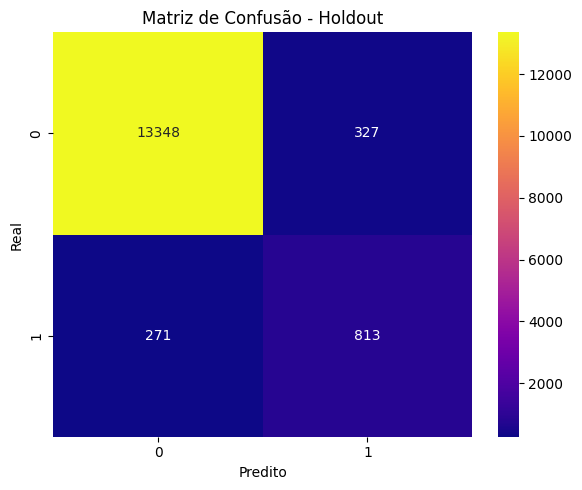

In [12]:
# === Hiperparâmetros ótimos para Random Forest ===
melhores_params = {
     'bootstrap': False,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 5,
     'n_estimators': 300,
     'random_state': 42,
     'n_jobs': -1,
     'verbose': 1  # ativa logs do Random Forest durante o fit
 }

# === Pipeline com SMOTE + Escalonamento + Random Forest ===
pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(**melhores_params))
])

# === Treinamento com o conjunto treino ===
print("\n=== Treinamento em hold-out com o modelo escolhido ===")
pipeline.fit(X_train, y_train)

# === Predição no holdout ===
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# === Métricas ===
report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_proba)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))
print(f"ROC AUC (teste): {roc_auc:.4f}")

# === Matriz de Confusão ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Holdout")
plt.tight_layout()
plt.show()

# === Barplot com principais métricas ===
metrics_dict = {
    "ROC AUC": roc_auc,
    "Acurácia": accuracy_score(y_test, y_pred),
    "Precisão (Classe 1)": precision_score(y_test, y_pred),
    "Recall (Classe 1)": recall_score(y_test, y_pred),
    "F1-Score (Classe 1)": f1_score(y_test, y_pred),
    "F1 Macro": report["macro avg"]["f1-score"],
    "F1 Weighted": report["weighted avg"]["f1-score"],
    "Classification_report": classification_report(y_test, y_pred, digits=4),
    "Confusion Matrix": confusion_matrix(y_test, y_pred),
}

# === Salvar dados de treinamento ===
with open('../data/processed/resultados_holdout_random_forest.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)


In [11]:
metrics_dict

{'ROC AUC': 0.9632453098754022,
 'Acurácia': 0.9594823497526933,
 'Precisão (Classe 1)': 0.7131578947368421,
 'Recall (Classe 1)': 0.75,
 'F1-Score (Classe 1)': 0.7311151079136691,
 'F1 Macro': 0.8546027653586078,
 'F1 Weighted': 0.959950898354693}

## Treinamento final do modelo com todos os dados 

In [ ]:
print("\n=== Treinamento final do modelo escolhido com todos os dados ===")
pipeline.fit(X, y)

# === Salvar modelo treinado ===
with open('../data/processed/final_random_forest_structure.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

print("Modelo salvo em '../data/processed/final_random_forest_structure.pkl'")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.5s finished


Modelo salvo em '../data/processed/final_random_forest_structure.pkl'


In [13]:
# Caminho do arquivo .pkl
caminho_arquivo = '../data/processed/resultados_holdout_random_forest.pkl'

# Abrindo o arquivo
with open(caminho_arquivo, 'rb') as arquivo:
    objeto = pickle.load(arquivo)

objeto

{'ROC AUC': 0.9632453098754021,
 'Acurácia': 0.9594823497526933,
 'Precisão (Classe 1)': 0.7131578947368421,
 'Recall (Classe 1)': 0.75,
 'F1-Score (Classe 1)': 0.7311151079136691,
 'F1 Macro': 0.8546027653586078,
 'F1 Weighted': 0.959950898354693,
 'Classification_report': '              precision    recall  f1-score   support\n\n           0     0.9801    0.9761    0.9781     13675\n           1     0.7132    0.7500    0.7311      1084\n\n    accuracy                         0.9595     14759\n   macro avg     0.8466    0.8630    0.8546     14759\nweighted avg     0.9605    0.9595    0.9600     14759\n',
 'Confusion Matrix': array([[13348,   327],
        [  271,   813]])}